In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline

from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import joblib

# 1. Cargando dataset al entorno

In [3]:
data = pd.read_csv('Schooling.csv')
data.head()

,Unnamed: 0,smsa66,smsa76,nearc2,nearc4,nearc4a,nearc4b,ed76,ed66,age76,...,lwage76,famed,black,wage76,enroll76,kww,iqscore,mar76,libcrd14,exp76
0,1,yes,yes,no,no,no,no,7,5,29,...,6.306275,9,yes,548,no,15.0,NaN,yes,no,16
1,2,yes,yes,no,no,no,no,12,11,27,...,6.175867,8,no,481,no,35.0,93.0,yes,yes,9
2,3,yes,yes,no,no,no,no,12,12,34,...,6.580639,2,no,721,no,42.0,103.0,yes,yes,16
3,4,yes,yes,yes,yes,yes,no,11,11,27,...,5.521461,6,no,250,no,25.0,88.0,yes,yes,10
4,5,yes,yes,yes,yes,yes,no,12,12,34,...,6.591674,8,no,729,no,34.0,108.0,yes,no,16


## 1.1 Eliminando la primera columna que funciona como ID 
#### Como se puede observar el dataset cuenta con 3010 filas y 28 columnas, dentro de las cuales se encuentran diversos tipos de datos.

In [4]:
data.drop('Unnamed: 0', axis=1, inplace=True)
#data.drop('lwage76', axis=1, inplace=True)

print(str(data.shape))

(3010, 28)


# 2. Análisis de la variable a predecir
#### Para el dataset seleccionado la variable a predecir es wage76 y es el salario que devenga la persona con base al resto de características, por lo que nos encontramos frente a un problema de regresión.
#### Como se puede observar en el siguiente gráfico la data está un poco sesgada a la izquierda, por lo que se hará una transformación logartímica para validar si se puede normalizar.

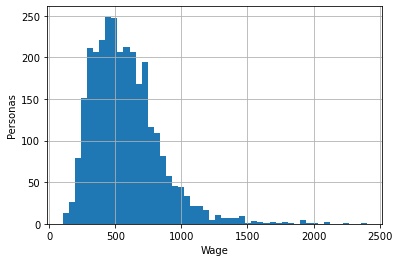

In [5]:
data['wage76'].hist(bins=50, density=False)
plt.xlabel("Wage")
plt.ylabel("Personas")
plt.show()

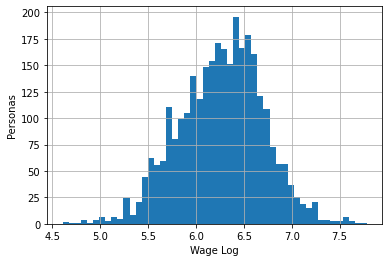

In [6]:
# Transformación logarítmica.
np.log(data['wage76']).hist(bins=50, density=False)
plt.xlabel("Wage Log")
plt.ylabel("Personas")
plt.show()

#### Como se esperaba, el resultado se distribuye de forma normal, por lo que se debería aplicar la transformación logarítmica a la variable.

## 2.1 Tipos de datos de las variables
### 2.1.1 Variables categóricas

In [7]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
#cantidad de variables categóricas
data[cat_vars] = data[cat_vars].astype('O')
print("El dataset contiene: ", len(cat_vars), "variables categóricas")

El dataset contiene:  17 variables categóricas


### 2.1.2 Variables numéricas

In [8]:
#variables numéricas
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'wage76')]
print("El dataset contiene: ", len(num_vars), "variables numéricas")

El dataset contiene:  10 variables numéricas


## 2.2 Análisis de valores faltantes

In [9]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
print("Existen: ", len(var_with_na), "variables con valores faltantes")
data[var_with_na].isnull().mean().sort_values(ascending=False)

Existen:  4 variables con valores faltantes


iqscore     0.315282
kww         0.015615
libcrd14    0.004319
mar76       0.002326
dtype: float64

#### La variable con más datos faltantes es iqscore, por lo que se evaluará si esta variable tiene mucha relación con la variable a predecir, para validar si es necesario realizar algún tipo de imputación, por otra parte el resto de variables contienen muy pocos valores faltantes, por lo que se analizará cual es la mejor opción para imputar los valores faltantes.

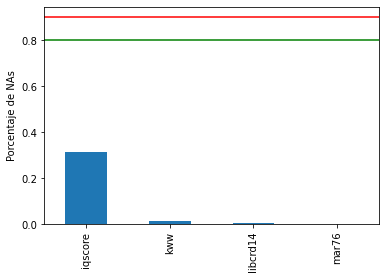

In [10]:
# Porcentajes de NAs.
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel("Porcentaje de NAs")
plt.axhline(y=0.9, color="r")
plt.axhline(y=0.8, color="g")

In [11]:
#variables categóricas con NAs.
cat_na = [var for var in cat_vars if var in var_with_na]
num_na = [var for var in num_vars if var in var_with_na]
print("Las variables categóricas con valores faltantes son:", cat_na)
print("Las variables numéricas con valores faltantes son: ", num_na)

Las variables categóricas con valores faltantes son: ['mar76', 'libcrd14']
Las variables numéricas con valores faltantes son:  ['kww', 'iqscore']


### 2.2.1 Verificando como los valores faltantes impactan en la variable a predecir

In [12]:
def na_impact_over_target(df, Xvar, Yvar):
    df = data.copy()
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind="barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

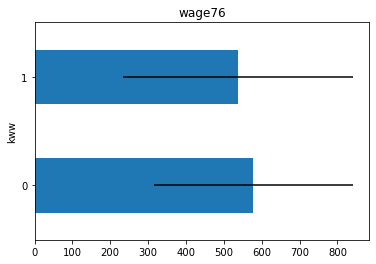

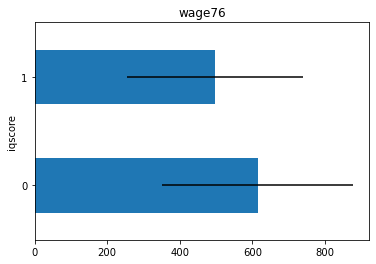

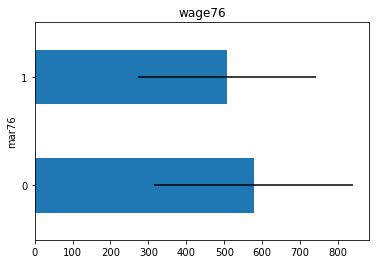

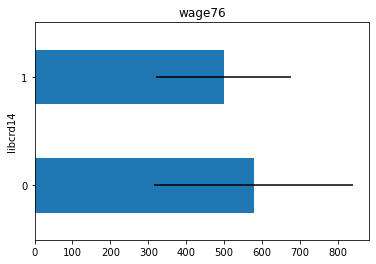

In [13]:
for var in var_with_na:
    na_impact_over_target(data, var, 'wage76')

## 2.3 Variables temporales
#### El dataset no cuenta con variables de timpo, por lo que esta sección no será desarrollada.

## 2.4 Variables discretas
#### En este apartado se analizará el comportamiento de aquellas variables que tienen menos de 20 valores distintos, el resto serán consideradas como variables continuas y se analizarán por aparte.


In [14]:
discrete_vars = [var for var in num_vars if((len(data[var].unique()) < 20))]
print("Las variables discretas son:", discrete_vars)
data[discrete_vars].head()

Las variables discretas son: ['ed76', 'ed66', 'age76', 'famed']


,ed76,ed66,age76,famed
0,7,5,29,9
1,12,11,27,8
2,12,12,34,2
3,11,11,27,6
4,12,12,34,8


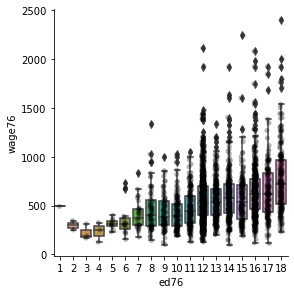

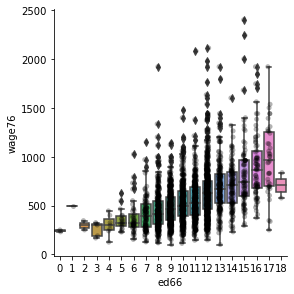

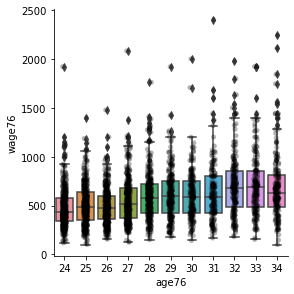

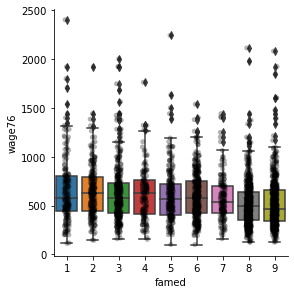

In [15]:
for var in discrete_vars:
    sns.catplot(x=var, y = 'wage76', data=data, kind="box", height=4)
    sns.stripplot(x=var, y='wage76', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

#### La variable "ed76", representa la cantidad de años de educación que una persona tenía en el año 76, por lo que se puede observar que a mayor educación en ese año, también sube el salario, sin embargo, la mayoría de personas se concentran en los 12 años de educación.
#### La variable "ed66" representa la cantidad de años que una persona había estudiado hasta el año 66, esta variable al igual que la anterior presenta que a mayor cantidad de años de educación más salario.
#### "aged76" representa la edad de la persona en el año 76, esta variable no muestra ningún cambio conforme la edad, es decir, que el salario no cambia por la edad de la persona.
#### La variable "famed", representa el nivel de educación de los padres, como se podría esperar esta variable no tiene mucha relación con la variable a predecir y más bien evidencia que esta característica no influye en los salarios de las personas.

# 2.5 Variables continuas

In [16]:
cont_vars = [var for var in num_vars if var not in discrete_vars]
print("Las variables continuas son: ", len(cont_vars))
data[cont_vars].head()

Las variables continuas son:  6


,daded,momed,lwage76,kww,iqscore,exp76
0,9.94,10.25,6.306275,15.0,NaN,16
1,8.00,8.00,6.175867,35.0,93.0,9
2,14.00,12.00,6.580639,42.0,103.0,16
3,11.00,12.00,5.521461,25.0,88.0,10
4,8.00,7.00,6.591674,34.0,108.0,16


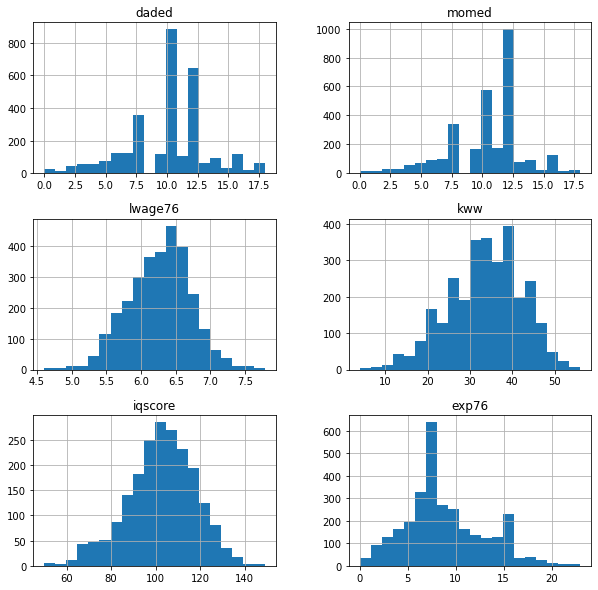

In [17]:
data[cont_vars].hist(bins=20, figsize=(10, 10))
plt.show()

#### Como se puede observar las variables casi no presentan sesgo, pero, se aplicará transformación sobre las variables  a efectos de validar si se pueden distribuir de mejor forma.

In [18]:
temp_yj = data.copy()

## 2.5.1 Aplicando transformación Yeo-Jonhnson

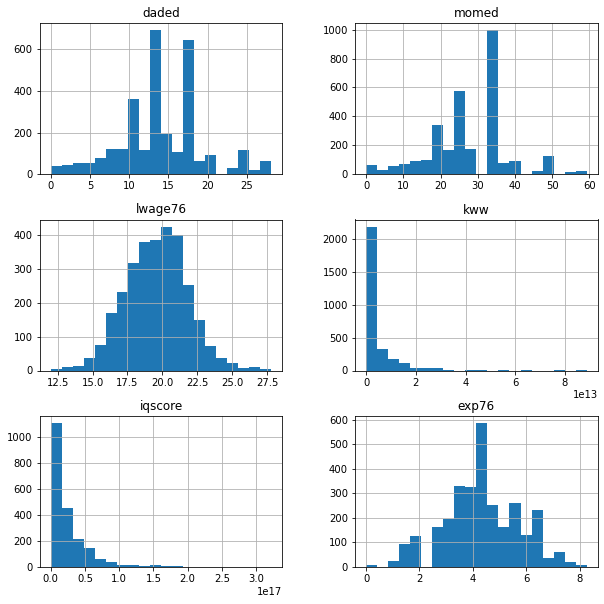

In [19]:
for var in cont_vars:
    temp_yj[var], param = stats.yeojohnson(data[var])

temp_yj[cont_vars].hist(bins=20, figsize=(10, 10))
plt.show()

#### La transformación de Yeo-Jonhson distribuye de mejor manera las variables daded y wage76, sin embargo, sesga las variables kww e iqscore, por lo que es posible que no sea apropiado aplicar esta transformación.

### 2.5.2 Transformación logarítmica

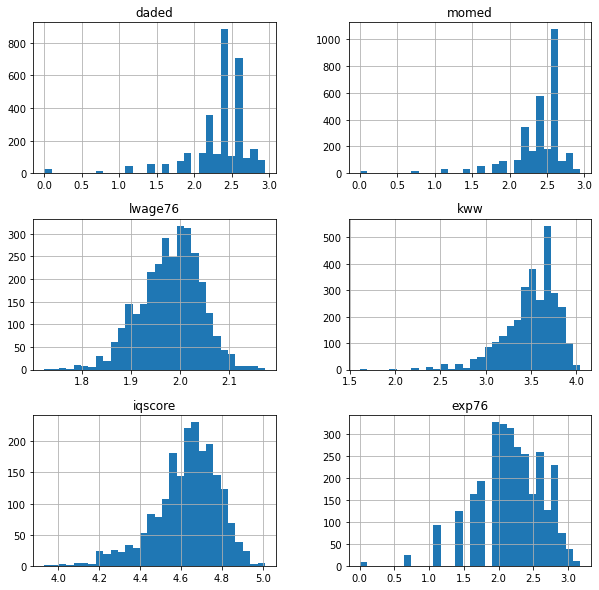

In [20]:
temp = data.copy()

for var in cont_vars:
    temp[var] = np.log(data[var] + 1)

temp[cont_vars].hist(bins=30, figsize=(10,10))
plt.show()

#### La transformación logarítmica de igual manera distribuye bien las primeras dos variables pero tiende a sesgar kww y iqscore.

### 2.5.3 Comparativo de transformaciones

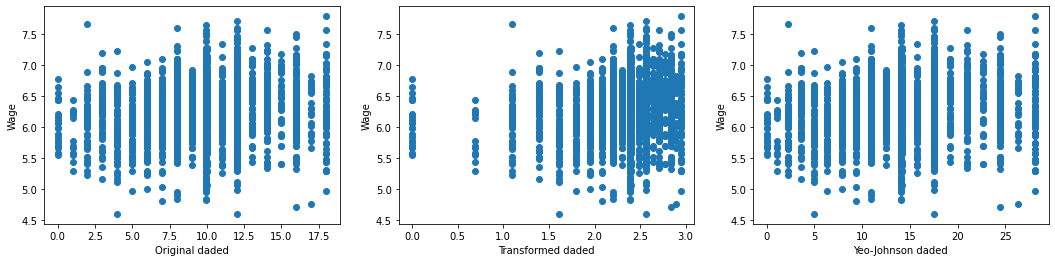

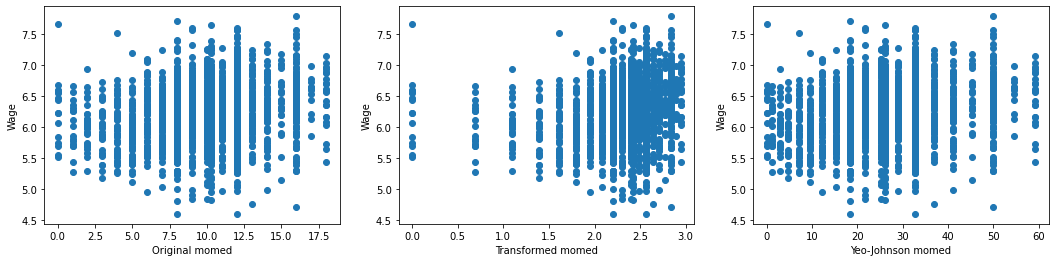

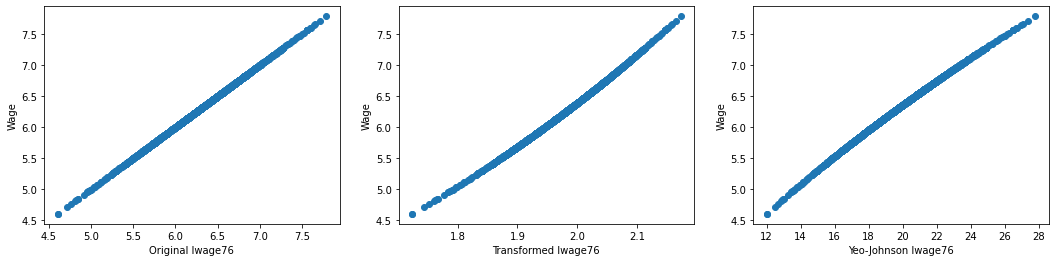

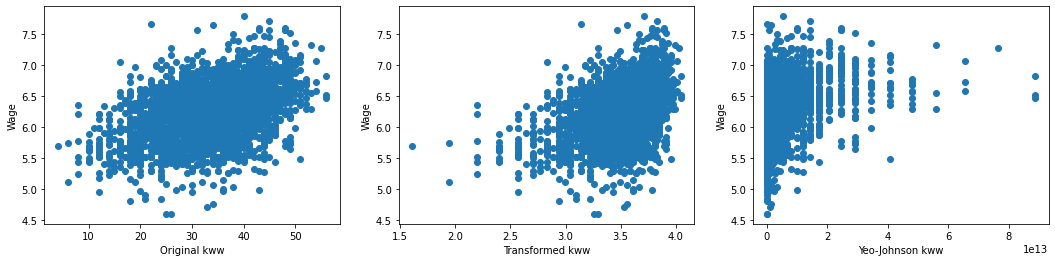

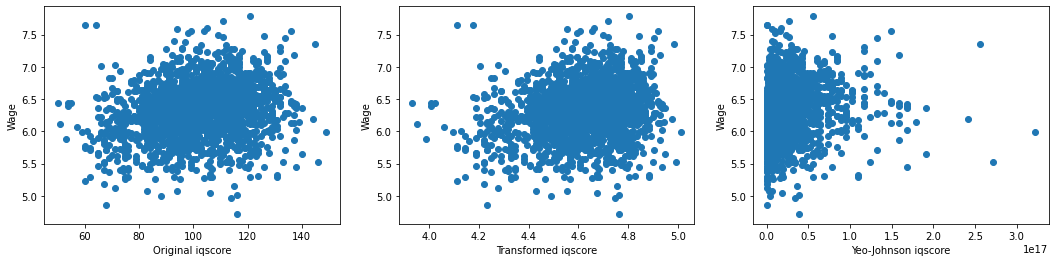

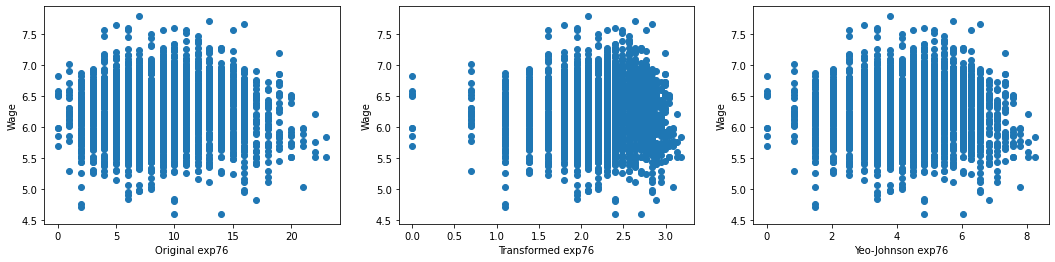

In [21]:
for var in cont_vars:
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data[var], np.log(data['wage76']))
    plt.ylabel("Wage")
    plt.xlabel("Original " + var)
    
    plt.subplot(1, 3, 2)
    plt.scatter(temp[var], np.log(data['wage76']))
    plt.ylabel("Wage")
    plt.xlabel("Transformed " + var)
    
    plt.subplot(1, 3, 3)
    plt.scatter(temp_yj[var], np.log(data['wage76']))
    plt.ylabel("Wage")
    plt.xlabel("Yeo-Johnson " + var)

    plt.show()

#### En todos los casos, se observa que estas variables es mejor dejarlas tal cual vienen en el dataset original ya que no presentaban sesgo.

## 2.6 Variables con sesgo
#### Como se pudo observar el dataset no cuenta con variables sesgadas, por lo que esta sección no será desarrollada

## 2.7 Variables categóricas

In [22]:
print("Las cantidad de variables categóricas son:", len(cat_vars))
data[cat_vars].head()

Las cantidad de variables categóricas son: 17


,smsa66,smsa76,nearc2,nearc4,nearc4a,nearc4b,nodaded,nomomed,momdad14,sinmom14,step14,south66,south76,black,enroll76,mar76,libcrd14
0,yes,yes,no,no,no,no,yes,yes,yes,no,no,no,no,yes,no,yes,no
1,yes,yes,no,no,no,no,no,no,yes,no,no,no,no,no,no,yes,yes
2,yes,yes,no,no,no,no,no,no,yes,no,no,no,no,no,no,yes,yes
3,yes,yes,yes,yes,yes,no,no,no,yes,no,no,no,no,no,no,yes,yes
4,yes,yes,yes,yes,yes,no,no,no,yes,no,no,no,no,no,no,yes,no


<AxesSubplot:>

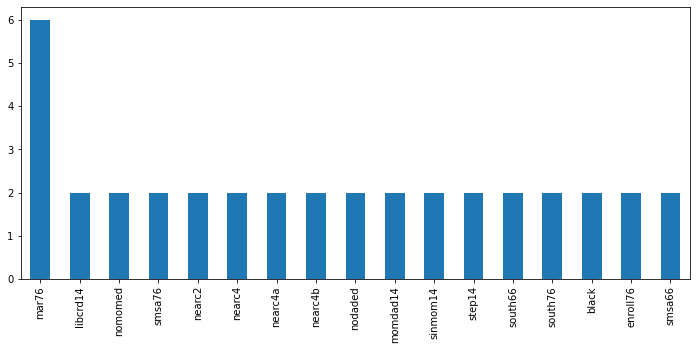

In [23]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

#### En la mayoría de casos las variables categóricas son binarias, ya que tienen únicamente dos resultados, la variable con más datos disstintos es mar76, que se refiere a si una persona está casada en el año 76

In [24]:
for var in cat_vars:
    data[var] = (data[var].astype('str'))
    diccio = {}
    diccio[var] = np.unique(data[var]) 
    print(diccio)

{'smsa66': array(['no', 'yes'], dtype=object)}
{'smsa76': array(['no', 'yes'], dtype=object)}
{'nearc2': array(['no', 'yes'], dtype=object)}
{'nearc4': array(['no', 'yes'], dtype=object)}
{'nearc4a': array(['no', 'yes'], dtype=object)}
{'nearc4b': array(['no', 'yes'], dtype=object)}
{'nodaded': array(['no', 'yes'], dtype=object)}
{'nomomed': array(['no', 'yes'], dtype=object)}
{'momdad14': array(['no', 'yes'], dtype=object)}
{'sinmom14': array(['no', 'yes'], dtype=object)}
{'step14': array(['no', 'yes'], dtype=object)}
{'south66': array(['no', 'yes'], dtype=object)}
{'south76': array(['no', 'yes'], dtype=object)}
{'black': array(['no', 'yes'], dtype=object)}
{'enroll76': array(['no', 'yes'], dtype=object)}
{'mar76': array(['2', '3', '4', '5', '6', 'nan', 'yes'], dtype=object)}
{'libcrd14': array(['nan', 'no', 'yes'], dtype=object)}


#### Como se mencionó anteiormente las variables contienen principalmente valores binarios, por lo que la codificación será más sencilla de realizar, únicamente quedan pendiente las variables que contienen valores nulos.

In [25]:
bin_vars = ['smsa66', 'smsa76', 'nearc2', 'nearc4', 'nearc4a', 'nearc4b', 'nodaded', 'nomomed', 'momdad14', 'sinmom14',
                'step14', 'south66', 'south76', 'black', 'enroll76', 'libcrd14']
bin_map = {'no': 0, 'yes': 1, 'nan': 0}
mar_var = ['mar76']
mar_map = {'nan': 0, 'yes': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}

In [26]:
for var in bin_vars:
    data[var] = data[var].map(bin_map)

In [27]:
for var in mar_var:
    data[var] = data[var].map(mar_map)

In [28]:
data[bin_vars].head()

,smsa66,smsa76,nearc2,nearc4,nearc4a,nearc4b,nodaded,nomomed,momdad14,sinmom14,step14,south66,south76,black,enroll76,libcrd14
0,1,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,1
4,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0


In [29]:
data[mar_var].head()

,mar76
0,1
1,1
2,1
3,1
4,1


#### El dataset quedó listo con respecto a las variables binarias y categóricas ya con los valores numéricos correspondientes.

#### Revisando el comportamietno de las variables categóricas respecto a la variable a predecir.

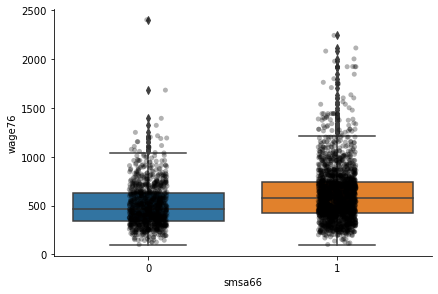

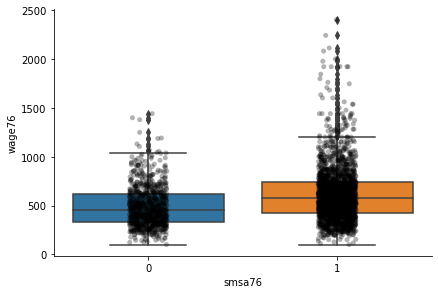

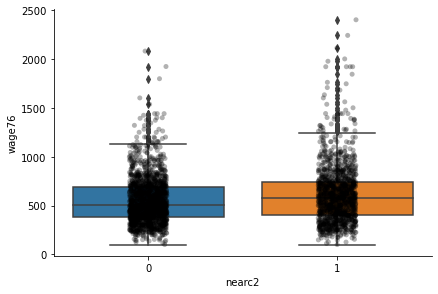

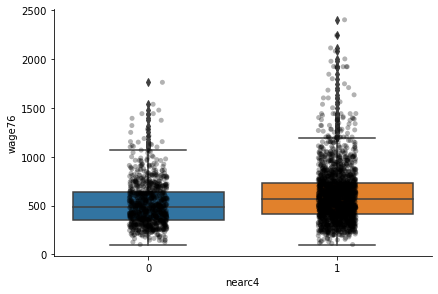

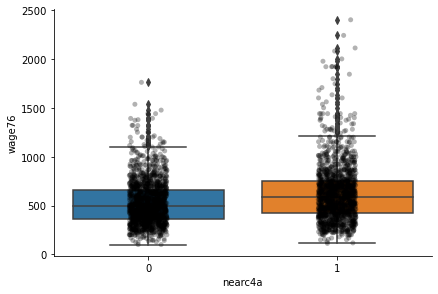

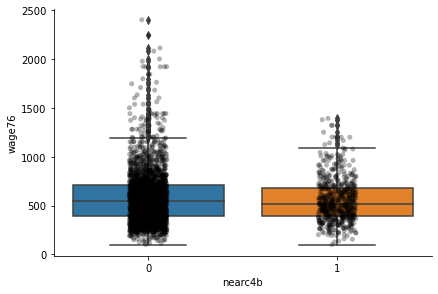

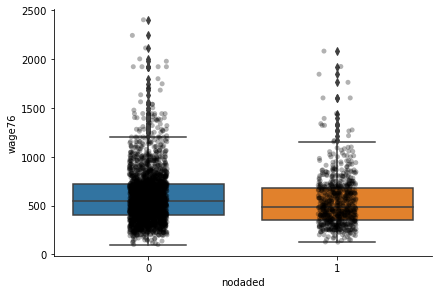

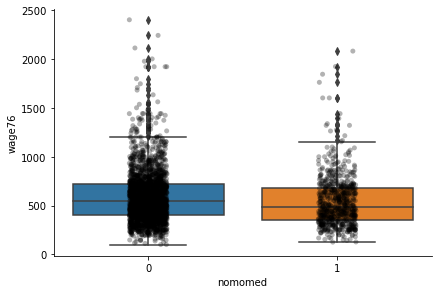

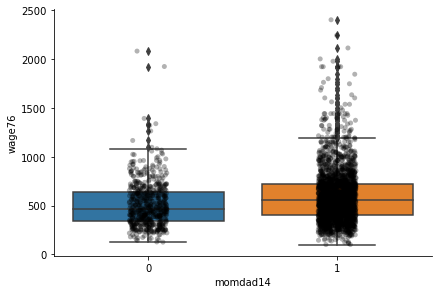

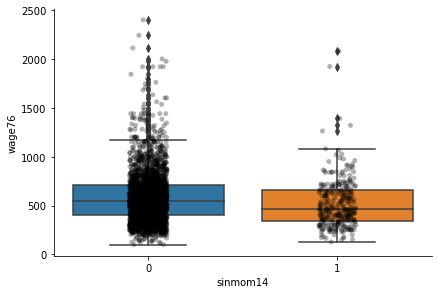

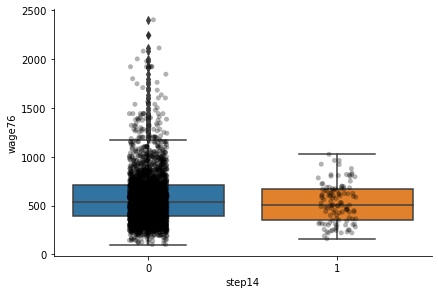

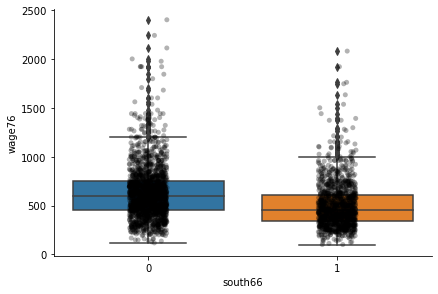

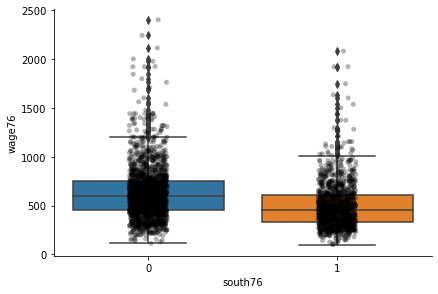

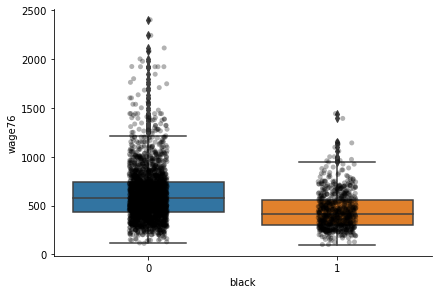

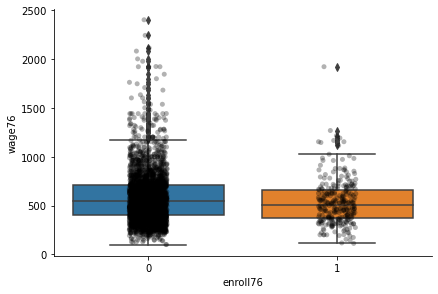

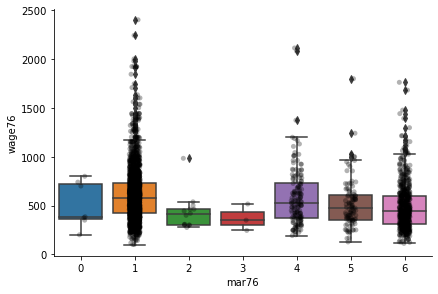

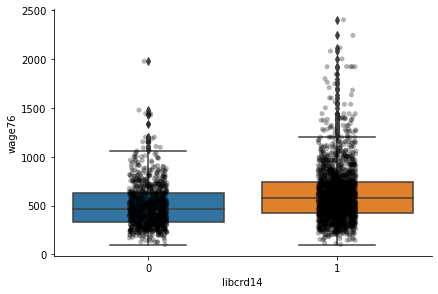

In [30]:
for var in cat_vars:
    sns.catplot(x=var, y = 'wage76', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='wage76', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

#### Como se puede observar en su mayoría las variables no cambian muchos su media, cuando los valores cambian entre si o no, sin embargo, es importante mencionar que hay ciertos campos donde la media si cambia dados sus valores, ejemplo de ello son south76 y south66, donde si las personas que han vivido en el sur de Estados Unidos ganan menos que las que no viven en el sur, otro dato relevante es la variable black, que se refiere al color de la piel de la persona, como se puede observar si una persona es afroamericana, generalmente gana menos.

## 2.8 Rare Labels
#### El dataset no contiene este tipo de variables, por lo que no será desarrollado.

In [31]:
data.head()

,smsa66,smsa76,nearc2,nearc4,nearc4a,nearc4b,ed76,ed66,age76,daded,...,lwage76,famed,black,wage76,enroll76,kww,iqscore,mar76,libcrd14,exp76
0,1,1,0,0,0,0,7,5,29,9.94,...,6.306275,9,1,548,0,15.0,NaN,1,0,16
1,1,1,0,0,0,0,12,11,27,8.00,...,6.175867,8,0,481,0,35.0,93.0,1,1,9
2,1,1,0,0,0,0,12,12,34,14.00,...,6.580639,2,0,721,0,42.0,103.0,1,1,16
3,1,1,1,1,1,0,11,11,27,11.00,...,5.521461,6,0,250,0,25.0,88.0,1,1,10
4,1,1,1,1,1,0,12,12,34,8.00,...,6.591674,8,0,729,0,34.0,108.0,1,0,16


# 3. Feature Engineering
#### En su mayoría las variables ya se encuentran listas para procesar, como se pudo observar, las variables categóricas fueron codificadas, además, las variables numéricas no presentaban un sesgo que se tuviera que transformar, por lo que solo faltaría analizar que hacer con los valores faltantes en las variables numéricas y transformar la variable a predecir como gaussiana.

## 3.1 Variables numéricas con NAs

In [32]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
print("Existen: ", len(var_with_na), "variables con valores faltantes")
data[var_with_na].isnull().mean().sort_values(ascending=False)

Existen:  2 variables con valores faltantes


iqscore    0.315282
kww        0.015615
dtype: float64

### 3.1.1 Tratamiento de faltantes en variables numéricas

In [33]:
for var in var_with_na:
    mean_val = data[var].mean()
    
    print(var, mean_val)
    
    data[var].fillna(mean_val, inplace=True)

kww 33.540668241646976
iqscore 102.44978165938865


In [34]:
print("El % de valores faltantes para las variables numéricas es:")
data[var_with_na].isnull().mean()

El % de valores faltantes para las variables numéricas es:


kww        0.0
iqscore    0.0
dtype: float64

## 3.2 Transformación de variables numéricas
#### En este caso se transformará únicamente la variable a predecir que es wage76 ya que como se pudo observar anteriormente, el resto de variables están distribuidas de manera uniforme.

In [35]:
#data['wage76'] = np.log(data['wage76'])

In [36]:
data.head()

,smsa66,smsa76,nearc2,nearc4,nearc4a,nearc4b,ed76,ed66,age76,daded,...,lwage76,famed,black,wage76,enroll76,kww,iqscore,mar76,libcrd14,exp76
0,1,1,0,0,0,0,7,5,29,9.94,...,6.306275,9,1,548,0,15.0,102.449782,1,0,16
1,1,1,0,0,0,0,12,11,27,8.00,...,6.175867,8,0,481,0,35.0,93.000000,1,1,9
2,1,1,0,0,0,0,12,12,34,14.00,...,6.580639,2,0,721,0,42.0,103.000000,1,1,16
3,1,1,1,1,1,0,11,11,27,11.00,...,5.521461,6,0,250,0,25.0,88.000000,1,1,10
4,1,1,1,1,1,0,12,12,34,8.00,...,6.591674,8,0,729,0,34.0,108.000000,1,0,16


#### El dataset se encuentra listo para realizar el entrenamiento.

### 3.3 Transformación de variables con sesgo
#### Este punto no será desarrollado ya que las variables no están sesgadas en la información original.

# 4 Feature Scaling

## 4.1 Separando el dataset en train y test

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['wage76'], axis=1),
                        data['wage76'],
                        test_size=0.15,
                        random_state=2021)

In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2558, 27) (452, 27) (2558,) (452,)


## 4.2 Creando el objeto scaler para generar la data

In [39]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [40]:
X_train.head()

,smsa66,smsa76,nearc2,nearc4,nearc4a,nearc4b,ed76,ed66,age76,daded,...,south76,lwage76,famed,black,enroll76,kww,iqscore,mar76,libcrd14,exp76
0,1.0,1.0,1.0,1.0,1.0,0.0,0.6250,0.666667,0.5,0.444444,...,0.0,0.739192,0.875,0.0,0.0,0.78,0.529796,0.166667,1.0,0.478261
1,0.0,0.0,0.0,0.0,0.0,0.0,0.8750,0.444444,0.0,0.888889,...,1.0,0.492006,0.125,0.0,0.0,0.66,0.454545,0.166667,1.0,0.086957
2,1.0,1.0,1.0,1.0,1.0,0.0,0.6250,0.500000,0.0,0.666667,...,0.0,0.506157,0.500,0.0,0.0,0.40,0.636364,0.166667,1.0,0.260870
3,1.0,1.0,1.0,1.0,1.0,0.0,0.6875,0.444444,0.0,0.666667,...,1.0,0.221120,0.250,0.0,0.0,0.32,0.529796,0.166667,1.0,0.217391
4,1.0,1.0,1.0,1.0,1.0,0.0,0.8125,0.777778,0.6,0.722222,...,0.0,0.621272,0.125,0.0,0.0,0.92,0.555556,0.166667,1.0,0.391304


## 4.3 Guardando dataset con salida csv

In [41]:
X_train.to_csv('preprocess_data/prep_Xtrain.csv', index=False)
X_test.to_csv('preprocess_data/prep_Xtest.csv', index=False)

y_train.to_csv('preprocess_data/prep_ytrain.csv', index=False)
y_test.to_csv('preprocess_data/prep_ytest.csv', index=False)

In [42]:
joblib.dump(scaler, 'preprocess_data/minmax_scaler.joblib')

['preprocess_data/minmax_scaler.joblib']

# 5. Selección de variables
## 5.1 Importación de dataset al entorno

In [43]:
X_train = pd.read_csv('preprocess_data/prep_Xtrain.csv')
X_test = pd.read_csv('preprocess_data/prep_Xtest.csv')
y_train = pd.read_csv('preprocess_data/prep_ytrain.csv')
y_test = pd.read_csv('preprocess_data/prep_ytest.csv')

In [44]:
X_train.head()

,smsa66,smsa76,nearc2,nearc4,nearc4a,nearc4b,ed76,ed66,age76,daded,...,south76,lwage76,famed,black,enroll76,kww,iqscore,mar76,libcrd14,exp76
0,1.0,1.0,1.0,1.0,1.0,0.0,0.6250,0.666667,0.5,0.444444,...,0.0,0.739192,0.875,0.0,0.0,0.78,0.529796,0.166667,1.0,0.478261
1,0.0,0.0,0.0,0.0,0.0,0.0,0.8750,0.444444,0.0,0.888889,...,1.0,0.492006,0.125,0.0,0.0,0.66,0.454545,0.166667,1.0,0.086957
2,1.0,1.0,1.0,1.0,1.0,0.0,0.6250,0.500000,0.0,0.666667,...,0.0,0.506157,0.500,0.0,0.0,0.40,0.636364,0.166667,1.0,0.260870
3,1.0,1.0,1.0,1.0,1.0,0.0,0.6875,0.444444,0.0,0.666667,...,1.0,0.221120,0.250,0.0,0.0,0.32,0.529796,0.166667,1.0,0.217391
4,1.0,1.0,1.0,1.0,1.0,0.0,0.8125,0.777778,0.6,0.722222,...,0.0,0.621272,0.125,0.0,0.0,0.92,0.555556,0.166667,1.0,0.391304


## 5.2 Creando el objeto selector de variables

In [45]:
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))
sel_.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64940.84018007852, tolerance: 17491.671463956212
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [46]:
sel_.get_support().sum()

26

#### Quedaron únicamente 2 variables de las 27 variables que tenía el dataset original

In [47]:
selected_features = X_train.columns[(sel_.get_support())]

In [48]:
selected_features

Index(['smsa66', 'smsa76', 'nearc2', 'nearc4a', 'nearc4b', 'ed76', 'ed66',
       'age76', 'daded', 'nodaded', 'momed', 'nomomed', 'momdad14', 'sinmom14',
       'step14', 'south66', 'south76', 'lwage76', 'famed', 'black', 'enroll76',
       'kww', 'iqscore', 'mar76', 'libcrd14', 'exp76'],
      dtype='object')

In [49]:
pd.Series(selected_features).to_csv('preprocess_data/selected_features.csv', index = False)

# 6. Entrenamiento del modelo
## 6.1 Selección de variables

In [50]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [51]:
# Creando el modelo

linear_model = Lasso(alpha = 0.001, random_state = 123)
linear_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64940.84020668268, tolerance: 17491.671463956212
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001, random_state=123)

In [52]:
# Creando las predicciones del modelo
preds_train = linear_model.predict(X_train )
preds_test = linear_model.predict(X_test)

## 6.2 Revisando el error del entrenamiento y del test
#### Como se puede observar el RMSE es bastante bajo de $90 para el set de entrenamiento, por lo que se ve que el modelo está reconociendo bien los patrones incluso con información que no conoce.

In [53]:
# Resultados del train
print("MSE del entrenamiento: {}".format(round(mean_squared_error((y_train), (preds_train)),5)))
print("RMSE del entrenamiento: {}".format(round(mean_squared_error((y_train), (preds_train), squared = False),5)))
print("R2 del entrenamiento: {}".format(round(r2_score((y_train), (preds_train)),5)))

MSE del entrenamiento: 6644.7035
RMSE del entrenamiento: 81.51505
R2 del entrenamiento: 0.90283


In [54]:
# Resultados del train
print("MSE del entrenamiento: {}".format(round(mean_squared_error((y_test), (preds_test)),5)))
print("RMSE del entrenamiento: {}".format(round(mean_squared_error((y_test), (preds_test), squared = False),5)))
print("R2 del entrenamiento: {}".format(round(r2_score((y_test), (preds_test)),5)))

MSE del entrenamiento: 8267.25756
RMSE del entrenamiento: 90.92446
R2 del entrenamiento: 0.88717


#### A continuación se presentan los resultados del modelo entrenado, a partir de $ 1000 la 

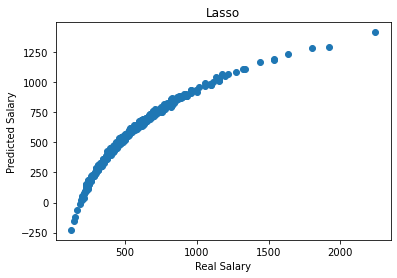

In [55]:
plt.scatter((y_test), (preds_test))
plt.xlabel("Real Salary")
plt.ylabel("Predicted Salary")
plt.title("Lasso")
plt.show()

## 6.3 Importancia de las variables

In [56]:
importance = pd.Series(np.abs(linear_model.coef_.ravel()))
importance.index = selected_features
importance.sort_values(inplace=True, ascending=False)

#### En su mayoría la variable que más aporta al modelo es lwage76, que se refiere al salario mínimo que podría ganar una persona, por lo que se podría inferir que la mayoría de personas ganan un salario mínimo.

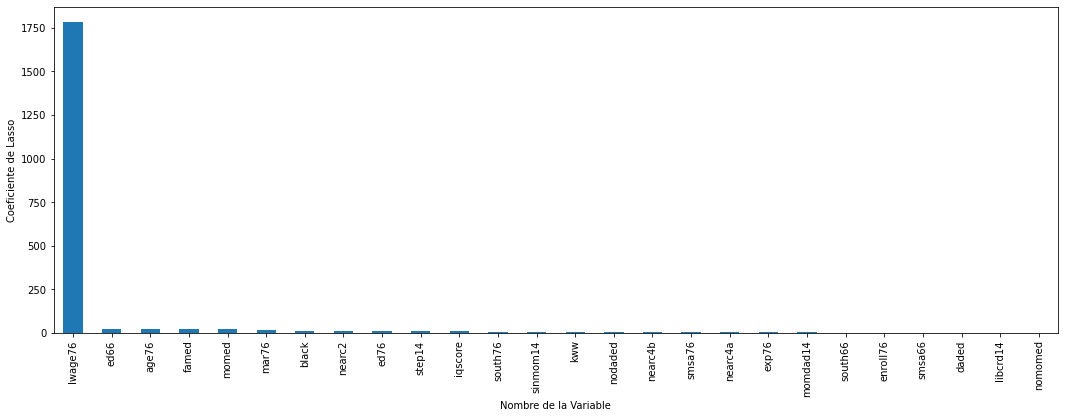

In [57]:
importance.plot.bar(figsize=(18, 6))
plt.ylabel("Coeficiente de Lasso")
plt.xlabel("Nombre de la Variable")
plt.show()

In [59]:
# Crear modelo final
joblib.dump(linear_model, 'final_model/lasso_reg.joblib')

['final_model/lasso_reg.joblib']

# 7. Configuración del Pipeline
## 7.1 Cargando modelo al entorno

In [65]:
data = pd.read_csv('Schooling.csv')

In [67]:
#Variables categoricas con NA
CATEGORICAL_VARS_WITH_NA = ['libcrd14', 'mar76']

CATEGORICAL_VARS_WITH_NA_FREQ = ['libcrd14', 'mar76']

#Variables numéricas con NA
NUMERICAL_VARS_WITH_NA = ['iqscore', 'kww']

#Variables para hacer mapeo categorico 
BINARY_VARS =  ['smsa66', 'smsa76', 'nearc2', 'nearc4', 'nearc4a', 'nearc4b', 'nodaded', 'nomomed', 'momdad14', 'sinmom14',
                'step14', 'south66', 'south76', 'black', 'enroll76', 'libcrd14']
MAR_VARS = ['mar76']

#Mapeos de variables categoricas
BINARY_MAP = {'no': 0, 'yes': 1, 'nan': 0}

MAR_MAP = {'nan': 0, 'yes': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}

#Variables seleccionadas según análisis de Lasso
FEATURES = ['smsa66', 'smsa76', 'nearc2', 'nearc4a', 'nearc4b', 'ed76', 'ed66',
       'age76', 'daded', 'nodaded', 'momed', 'nomomed', 'momdad14', 'sinmom14',
       'step14', 'south66', 'south76', 'lwage76', 'famed', 'black', 'enroll76',
       'kww', 'iqscore', 'mar76', 'libcrd14', 'exp76']

## 7.2 Machine Learning Pipeline

In [68]:
Salary_pipeline = Pipeline([
    
    #============= IMPUTACIONES ===================#
    
    #1. Imputación de varaibles categoricas
    #('missing_imputation', 
    #     CategoricalImputer(imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA)
    #),
    
    #2. Imputación de variables categoricas con NA basado en frequiencia.
    ('frequent_imputation', 
         CategoricalImputer(imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQ)
    ),
    
    #3. Indicamos Faltante en variables numéricas para imputar
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
    
    #4. Imputación de mediana para variables categoricas
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    )
    
    #============= VARIABLES TEMPORALES ==================
    
    #5. Tratamiento de variables temporales
    #('eslapsed_time', mypp.TremporalVariableTransformer(
    #    variables=TEMPORAL_VARS, reference_variable=REF_VAR)
    #),
    
    #6. Drop de variables
    #('drop_features', DropFeatures(features_to_drop=DROP_FEATURES)),
    
    #============= TRANSFORMACIÓN DE VARIABLES NUMÉRICAS =============
    
    #7. Transformación logaritmica
    #('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
    #8. Binarización de Variables con Sesgo Fuerte
    #('binarizer', SklearnTransomerWrapper(
    #    transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)
    #)
    
]) 

In [69]:
Salary_pipeline

Pipeline(steps=[('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['libcrd14', 'mar76'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['iqscore', 'kww'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['iqscore', 'kww']))])